Theano Tutorial @ LTI, Carnegie Mellon University
=======================

Kazuya Kawakami, clab

# Theano

Theano is a Python library, like numpy, that lets you to define mathematical expressions and run them on GPU.  
In short, Theano is the best prototyping tool!!

**Pros**

- **Python** : Preprocessing, Modeling, Visualization. Numpy like expression.
- **Easy to access GPU**: You don't need to do anything!!
- **Execution speed optimizations**: Theano can use g++ or nvcc to compile your expression graph
- **Symbolic differentiation**: Automatic Differentiation on symbolic expressions
- **Stability optimizations**: Theano recognize numerically unstable expressions and fix them
- **Still growing**: Developer communitiy is active

**Cons**

- **Loop** : Restrictions on how the loop interact with the rest of the graph
- ** Goto/Recursion**: are not supprted

## Contents
0. **Tools**: You don't need to know theano at all !! ( [nolearn](https://github.com/dnouri/nolearn.git), [Pylearn2](http://deeplearning.net/software/pylearn2/), [sklearn-theano](http://sklearn-theano.github.io/auto_examples/plot_mnist_generator.html#example-plot-mnist-generator-py) ).

1. **Overview**: How theano codes look like??
2. **Variables**: Symbolic variable, Shared variable
3. **Function, Computational Graph**: tensor.function, tensor.clone, theano.printing.pp, theano.printing.debugprint
4. **Math**:  Comparison, Condition
5. **Linear Algebra**
6. **Gradient**: theano.gradient.grad, theano.gradient.hessian, theano.gradient.jacobian, update
7. **GPU**: Data type 
8. **Linear Regression**
9. **Multi Layer Perceptron**
10. **Convolution**
11. **Maxpooling**
12. **Scan**
13. **Recurrent Neural Networks**
14. **Tips for debugging**
15. **Links**

##Server

This is a hands-on tutorial, if you sent your public key to Prasanna, you can log in to your server.
The server has 4 GPUs. To avoid all participants uses one gpu, please specify explicitly the gpu you want to use.

In [2]:
import theano.sandbox.cuda
theano.sandbox.cuda.use("cpu") #gpu1, gpu2, gpu3

ERROR (theano.sandbox.cuda): nvcc compiler not found on $PATH. Check your nvcc installation and try again.
ERROR:theano.sandbox.cuda:nvcc compiler not found on $PATH. Check your nvcc installation and try again.


If you are running command line, run your code with the following options.

```bash
THEANO_FLAGS=mode=FAST_RUN,device=gpu0,floatX=float32, python your_code.py
THEANO_FLAGS=mode=FAST_RUN,device=gpu1,floatX=float32, python your_code.py
THEANO_FLAGS=mode=FAST_RUN,device=gpu2,floatX=float32, python your_code.py
THEANO_FLAGS=mode=FAST_RUN,device=gpu3,floatX=float32, python your_code.py
```

Then launch your ipython server by following this [Instruction](http://ipython.org/ipython-doc/1/interactive/public_server.html).

## Tools

There are a lots of tools implemented with Theano.
For example, [nolearn](https://github.com/dnouri/nolearn.git) let you write image classification in 30 lines !! 

More examples and tutorials are in [dl_tutorial](https://github.com/oduerr/dl_tutorial/tree/master/lasagne).

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
from collections import OrderedDict

import numpy
import theano
import theano.tensor as T
from theano.sandbox.rng_mrg import MRG_RandomStreams as RandomStreams

trng = RandomStreams(42)

from sklearn.datasets import fetch_mldata
from sklearn.utils import shuffle
from sklearn.cross_validation import train_test_split
from sklearn.metrics import f1_score

#Random Seed
rng = numpy.random.RandomState(1234)

mnist = fetch_mldata('MNIST original')

# mnist_x is a (n_sample, n_feature=784) matrix
mnist_x, mnist_y = mnist.data.astype("float32")/255.0, mnist.target.astype("int32")

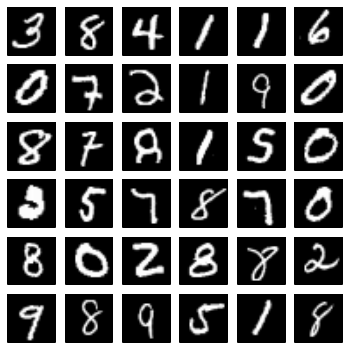

In [5]:
## Show Randomly picked Examples
def plot_sample(x, axis):
    img = x.reshape(28, 28)
    axis.imshow(img, cmap='gray')
    
fig = plt.figure(figsize=(6, 6))
for i in range(36):
    ax = fig.add_subplot(6, 6, i + 1, xticks=[], yticks=[])
    plot_sample(mnist_x[numpy.random.randint(0,60000)], ax)

## Overview of Theano code

1. Define Symbolic/Shared variables (**Variables**)
2. Construct a computational graph (**Math**)
3. Compile the graph (**Function**)
4. Run!!

In [6]:
# Linear Regression
import numpy
import theano
import theano.tensor as T

##  Step1. Define Symbolic / Shared Variables
x, t = T.fvector("x"), T.fvector("t") #input

W = theano.shared(rng.uniform(low=-0.08,high=0.08, size=(5, 3)), name="W") #variables that are shared over iteration: weight, bias
b =  theano.shared(numpy.zeros(3), name="bias")


## Step2. Define graph
y = T.dot(x, W) + b

cost = T.sum((y - t)**2) #Cost function

gW, gb = T.grad(cost, [W, b]) # Take gradient

updates =  OrderedDict({W: W-0.01*gW, b: b-0.01*gb}) # Set update expression in OrderedDict


## Step3. Compile graph
f = theano.function(inputs=[x, t], outputs=[cost, gW, gb], updates=updates, allow_input_downcast=True)


## Step4. Run!!
for epoch in range(5):
    cost, gW, gb = f([-2., -1., 1., 2., 3.], [.4, .3, .5])
    print "epoch:: %d, cost:: %.3f"%(epoch, cost)

epoch:: 0, cost:: 0.295
epoch:: 1, cost:: 0.106
epoch:: 2, cost:: 0.038
epoch:: 3, cost:: 0.014
epoch:: 4, cost:: 0.005


## Variables

In addition to numpy.ndarray, you need to know **Symbolic Variable** and **Shared Variable**.

- **Symbolic Variable** is a symbolic representation of quantities you want to use in functions. (Inputs)
- **Shared Variable** is a variable with **storage** that is shared between functions. (Weights, Data)

In [7]:
## Symbolic Variables 
a = T.iscalar("a")   # integer
b = T.fscalar("b")  # float scalar

x = T.fvector("x")  # float vector
X = T.fmatrix("X") # float matrix

## Shared Variable, store variables on cpu/gpu memory
W = theano.shared(numpy.array([0., 1., 2., 3., 4.]).astype("float32"), name="W")
bias  = theano.shared(numpy.float32(5), name="bias")

# Get Value from shared variable
print W.get_value() 

## Define symbolic graph
c = a + b
y = T.dot(x, W) + bias

## Print symbolic graph
print theano.pp(y)

##  Advanced:: You can replace some parts of computation graph with different variable
d = theano.clone(output=c, replace={b: y}) #replace "b" with "y"
print theano.pp(d)

[ 0.  1.  2.  3.  4.]
((x \dot W) + bias)
(a + ((x \dot W) + bias))


## Function

Compile symbolic graph into a function

** BE CAREFUL**:: YOU NEED TO USE int32 or float32, only computations with float32 data-type can be accelerated.

In [8]:
## Compile symbplic graph into callable functions
add = theano.function(inputs=[a, b], outputs=c)
linear = theano.function(inputs=[x], outputs=y)

## Call Functions
print add(1, 5)
print linear([0., 0., 0., 0., 1.]).astype("float32")

##Print function
theano.printing.debugprint(linear)

## Advanced :: You can evaluate symbolic graph without compilation
print c.eval({
                        a : numpy.int32(16), 
                        b : numpy.float32(12.10)
                     })

6.0
9.0
Elemwise{Add}[(0, 0)] [@A] ''   4
 |InplaceDimShuffle{} [@B] ''   3
 | |CGemv{inplace} [@C] ''   2
 |   |Alloc [@D] ''   1
 |   | |TensorConstant{0.0} [@E]
 |   | |TensorConstant{1} [@F]
 |   |TensorConstant{1.0} [@G]
 |   |InplaceDimShuffle{x,0} [@H] ''   0
 |   | |W [@I]
 |   |x [@J]
 |   |TensorConstant{0.0} [@E]
 |bias [@K]
28.1000003815


## Math

Most mathmatic operations are similar to numpy. However, comparison operations have special form. [[Basics](http://deeplearning.net/software/theano/library/tensor/basic.html)]

 Condition operation is 
 ```python
 T.switch(condition, if true, if false)
 ```
 
 Comparison is 
 
 ```python
 T.gt(a, b) #Greater Than
 ```

In [9]:
x = T.fvector("x")

### Basic Math operation & Activation funcsions
exp_x = T.exp(x)
sigmoid_x = T.nnet.sigmoid(x)
tanh_x = T.tanh(x)

### Advanced:: condition and comparison
relu_x = T.switch(T.gt(x, 0), x, 0)

f = theano.function([x], [exp_x, sigmoid_x, tanh_x, relu_x])
f(numpy.array([-2., -1., 1., 2., 3.]).astype("float32"))

[array([  0.13533528,   0.36787945,   2.71828175,   7.38905621,  20.08553696], dtype=float32),
 array([ 0.11920292,  0.26894143,  0.7310586 ,  0.88079709,  0.95257413], dtype=float32),
 array([-0.96402758, -0.76159418,  0.76159418,  0.96402758,  0.99505478], dtype=float32),
 array([ 0.,  0.,  1.,  2.,  3.], dtype=float32)]

## Gradient (Automatic Differentiation)

You can define gradient symbolically. Amazing!!

If you want to use Jacobian or Hessian, use theano.gradient.jacobian,  theano.gradient.hessian.

In [10]:
# y = x ** 2
x = T.fscalar("x")
y = x ** 2
gy = theano.grad(cost=y, wrt=x) ## 2x

f = theano.function([x], [y, gy]) ## x**2, 2x
print f(10)

[array(100.0, dtype=float32), array(20.0, dtype=float32)]


**Updateing your parameters (shared variables)** is the key process, but it's a bit complicated.

Let's start from a toy example.

In [11]:
##Define a function which update t by 1 for each call.

t = theano.shared(numpy.int32(0))
increment = theano.function([], t, updates=OrderedDict({t: t+1}) ) #OrderedDict({before update: after update})
for i in range(5):
    t = increment()
    print t

0
1
2
3
4


In [12]:
# Linear Regression
from collections import OrderedDict
rng = numpy.random.RandomState(1234)

##  Step1. Define Symbolic / Shared Variables
x, t = T.fvector("x"), T.fvector("t") #inputs


W = theano.shared(rng.uniform(low=-0.08,high=0.08, size=(5, 3)), name="W") #variables that are shared over iterations
b =  theano.shared(numpy.zeros(3), name="bias")


## Step2. Define graph
y = T.dot(x, W) + b
#y = T.nnet.sigmoid(T.dot(x, W) + b)
#y = T.tanh(T.dot(x, W) + b)
cost = T.sum((y - t)**2)


gW, gb = T.grad(cost, [W, b]) # Take gradient

updates =  OrderedDict({W: W-0.01*gW, b: b-0.01*gb}) # Set update expression in OrderedDict


## Step3. Compile graph
f = theano.function(inputs=[x, t], outputs=[cost, gW, gb], updates=updates, allow_input_downcast=True)

## Step4. Run!!
for epoch in range(5):
    cost, gW, gb = f([-2., -1., 1., 2., 3.], [.4, .3, .5])
    print "epoch:: %d, cost:: %.3f"%(epoch, cost)

epoch:: 0, cost:: 0.295
epoch:: 1, cost:: 0.106
epoch:: 2, cost:: 0.038
epoch:: 3, cost:: 0.014
epoch:: 4, cost:: 0.005


**Since we have Autodiff, it's easy to change linear regression to non-linear regression.** Try it!!

## Multi Layer Perceptron (MLP) 

<img src="http://k-kawakami.com/img/mlp.png">

In [12]:
#Multi Layer Perceptron
class Layer:
    def __init__(self, in_dim, out_dim, function):
        ########
        self.params = [ ]

    def fprop(self, x):
        #####
        pass
    
class Dropout():
    def __init__(self, p):
        self.p = p
        self.params = []

    def fprop(self, x, use_noise=True):
        #####
        pass

In [13]:
train_x, valid_x, train_y, valid_y = train_test_split(mnist_x, mnist_y, test_size=0.2, random_state=42)

In [14]:
x, t = T.fmatrix("x"), T.ivector("t")
activation = T.nnet.sigmoid #T.tanh

layers = [
    # WRITE ME
]

## Collect Parameters and Symbolic output
params = []
for i, layer in enumerate(layers):
    params += layer.params
    if i == 0:
        layer_out = layer.fprop(x)
    else:
        layer_out = layer.fprop(layer_out)

        
## Cost Function (Negative Log Likelihood)

## Get Gradient

## Defile Learning Rule, you can add Adagrad, Adadelta etc.
lr, momentum = numpy.float32(0.1), numpy.float32(0.9)

for param, gparam in zip(params, gparams):
    # sgd
    pass

## Compile 
#train = theano.function([x,t], cost, updates=updates)
#test = theano.function([x,t],[cost, T.argmax(y, axis=1)])

NameError: name 'gparams' is not defined

In [18]:
## Iterate


####Exercises: Squeeze out the last few percent!!
1. Try other objectives, MSE, Cross Entropy. 
2. Try symmetric activation functions (tanh, softsign).
3. Implement ReLU (Hint. look at Math section).
4. Add Dropout (Hint. apply random mask to inputs in fprop).
5. Add learning rate adjuster (Hint. make learning rate as shared variable).

## References
1. [Theano Documentation](http://deeplearning.net/software/theano/introduction.html)
2. [Deep Learning Tutorial](http://deeplearning.net/tutorial/)
3. F. Bastien, P. Lamblin, R. Pascanu, J. Bergstra, I. Goodfellow, A. Bergeron, N. Bouchard, D. Warde-Farley and Y. Bengio. [Theano: new features nd speed improvements"](http://arxiv.org/pdf/1211.5590.pdf). NIPS 2012 deep learning workshop.
4. J. Bergstra, O. Breuleux, F. Bastien, P. Lamblin, R. Pascanu, G. Desjardins, J. Turian, D. Warde-Farley and Y. Bengio. [Theano: A CPU and GPU Math Expression Compiler](http://www.iro.umontreal.ca/~lisa/pointeurs/theano_scipy2010.pdf). Proceedings of the Python for Scientific Computing Conference (SciPy) 2010. June 30 - July 3, Austin, TX
5. [Wikipedia, Convolution](https://en.wikipedia.org/wiki/Convolution)
6. [Stanford UFLDL Tutorial](http://ufldl.stanford.edu/wiki/index.php/UFLDL_Tutorial)

## Acknowledgements

Thank you Guillaume Lample, Ramón Fernandez Astudillo, Chu-Cheng Lin for reviewing this tutorial. 

And I appreciate Theano developers!!!